In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

In [2]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

In [166]:
PATCH_SIZE = 227

WEIGHTS_FILE = '/home/jing/Documents/CNN_tabletennis/example_classifier_iter_10000.caffemodel'
DEPLOY_FILE = '/home/jing/Documents/CNN_tabletennis/models/classifier_deploy.prototxt'
MEAN_FILE = '/home/jing/Documents/CNN_tabletennis/data/mean.npy'

In [172]:
mu = np.load(MEAN_FILE)
mu = mu.mean(1).mean(1)
print mu

net = caffe.Net(DEPLOY_FILE, WEIGHTS_FILE, caffe.TEST)

transformer = caffe.io.Transformer({'data':net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))#nChannels w h?
transformer.set_mean('data', mu)
transformer.set_raw_scale('data', 255)
transformer.set_channel_swap('data', (2,1,0))#RGB to BGR

[ 120.84302377   95.50270232  100.48351717]


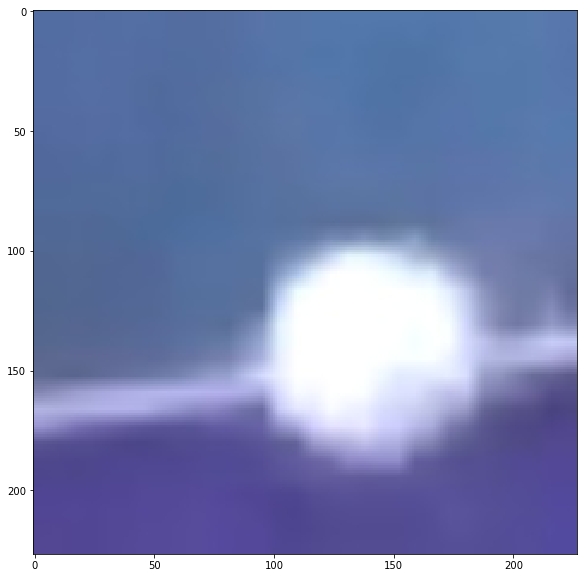

In [182]:
img_name = '/home/jing/Documents/TableTennis/TableTennis/build/tabletennis_test/0013R025103.jpg'

#batch_size = net.blobs['data'].data.shape[0]

image = caffe.io.load_image(img_name)
plt.imshow(image)

In [183]:
transformed_image = transformer.preprocess('data', image)
net.blobs['data'].data[0,...] = transformed_image

output = net.forward()

#class_pred = output['my_cls_score'][0]
class_pred = output['my_fc8'][0]
#bbox_pred = output['my_pred'][0]

print 'predicted class is ', class_pred.argmax()
print 'class score: ', class_pred
#print 'bbox is ', bbox_pred*PATCH_SIZE

predicted class is  1
class score:  [-19.15248871  15.62687969]


In [79]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(1, 3, 227, 227)
conv1	(1, 96, 55, 55)
pool1	(1, 96, 27, 27)
norm1	(1, 96, 27, 27)
conv2	(1, 256, 27, 27)
pool2	(1, 256, 13, 13)
norm2	(1, 256, 13, 13)
conv3	(1, 384, 13, 13)
conv4	(1, 384, 13, 13)
conv5	(1, 256, 13, 13)
pool5	(1, 256, 6, 6)
my_fc6	(1, 4096)
my_fc7	(1, 4096)
my_fc8	(1, 2)


In [80]:
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)

conv1	(96, 3, 11, 11) (96,)
conv2	(256, 48, 5, 5) (256,)
conv3	(384, 256, 3, 3) (384,)
conv4	(384, 192, 3, 3) (384,)
conv5	(256, 192, 3, 3) (256,)
my_fc6	(4096, 9216) (4096,)
my_fc7	(4096, 4096) (4096,)
my_fc8	(2, 4096) (2,)


In [81]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

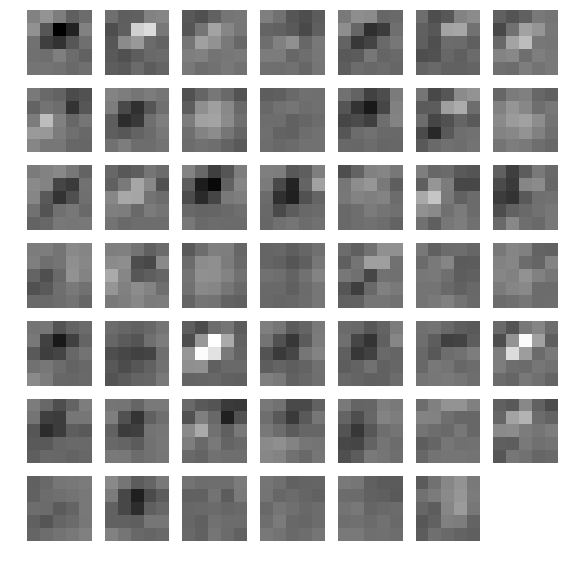

In [191]:
# the parameters are a list of [weights, biases]
#filters = net.params['conv1'][0].data
#vis_square(filters.transpose(0, 2, 3, 1))
filters = net.params['conv2'][0].data
vis_square(filters[1])
#print filters[4][3]

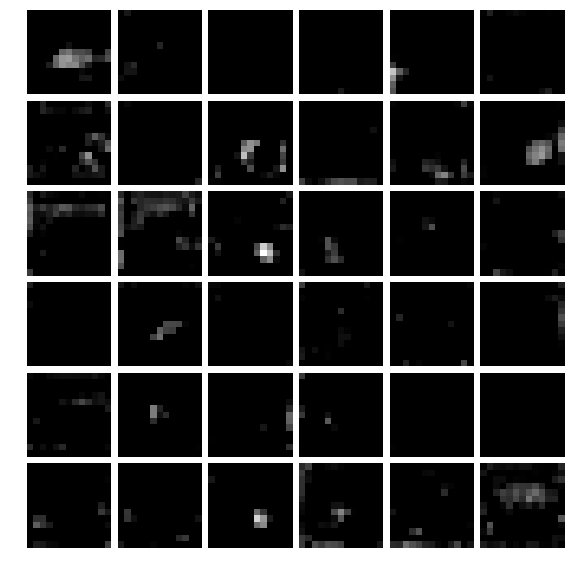

In [197]:
feat = net.blobs['my_conv5'].data[0, :36]
vis_square(feat)

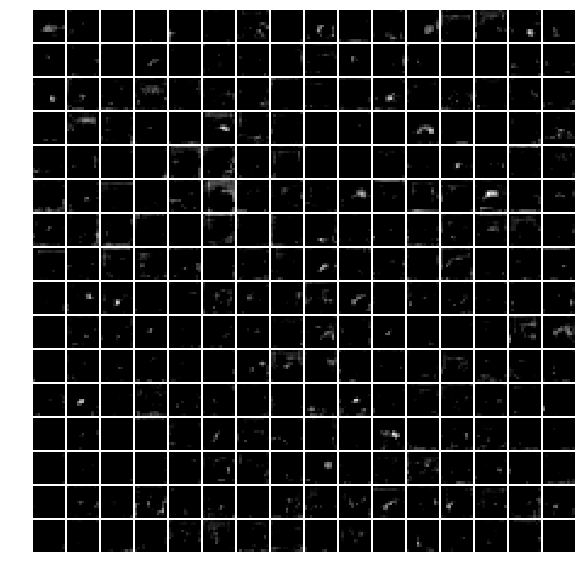

In [198]:
feat = net.blobs['my_conv5'].data[0]
vis_square(feat)

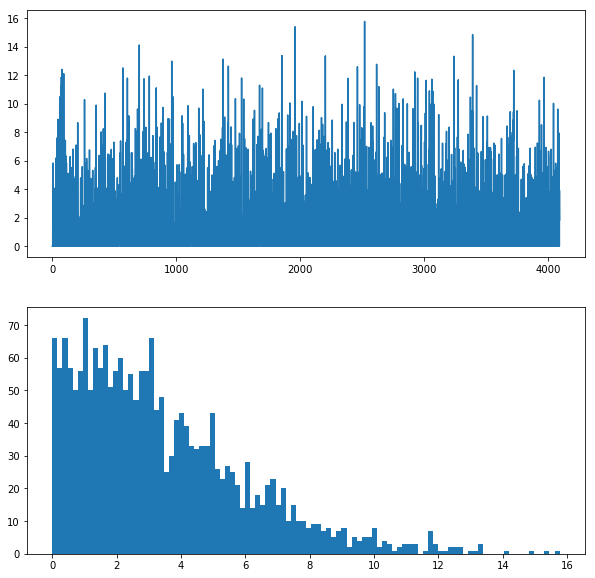

In [186]:
feat = net.blobs['my_fc6'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

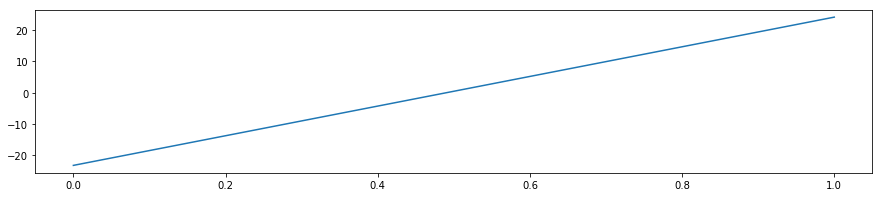

In [165]:
feat = net.blobs['my_fc8'].data[0]
plt.figure(figsize=(15, 3))
plt.plot(feat.flat)